In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import numpy as np
from scipy.integrate import quad
from scipy.special import hyp2f1
import math
from scipy.integrate import trapezoid
import corner

In [2]:
def erfcx(x):
    # Define a vectorized function that forces each element to be a float.
    vec_func = np.vectorize(lambda xi: math.exp(float(xi)*float(xi)) * math.erfc(float(xi)))
    return vec_func(x)


In [3]:
# def my_erf(x):
#     return math.erf(x)


def my_erf(x):
    """Vectorized error function using math.erf."""
    # np.vectorize will apply math.erf element‐by‐element
    return np.vectorize(math.erf)(x)


# decay check

# simulator - psiam + tied decay

In [4]:
def decay_amount_tied_fn(t, gamma, mu_d, sigma_d, alpha):
    return np.exp(-t/gamma) +  (alpha / (1 + np.exp(-(t - mu_d) / sigma_d )))


def simulate_psiam_tied_decay(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    gamma, mu_d, sigma_d, alpha = (decay_params[k] for k in ["gamma", "mu_d", "sigma_d", "alpha"])

    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))

    is_act = 0
    while True:
        if t > t_stim + t_E_aff:
            decay = decay_amount_tied_fn(t - t_stim - t_E_aff, gamma, mu_d, sigma_d, alpha)
            mu = common * (rate_lambda * ILD / chi) * decay
            sigma = np.sqrt(common * decay)

            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t
            break
        elif DV <= -theta:
            choice = -1; RT = t
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            while t <= (AI_hit_time + t_E_aff):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    decay = decay_amount_tied_fn(t - t_stim - t_E_aff, gamma, mu_d, sigma_d, alpha)
                    mu = common * (rate_lambda * ILD / chi) * decay
                    sigma = np.sqrt(common * decay)

                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time
        if DV > 0:
            choice = 1
        elif DV < 0:
            choice = -1
        else: # if DV is 0 because stim has not yet been played, then choose right/left randomly
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1       
    
    return choice, RT, is_act


# sim wrapper

In [5]:
def psiam_tied_decay_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    t_stim = random.choice(t_stim_arr)
    
    
    choice, rt, is_act = simulate_psiam_tied_decay(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim}

# get ABL ILD and stim

In [6]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)
# t_stim_arr = np.random.choice(df['intended_fix'], N_sim)


print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# Sim params

In [7]:
# V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt
V_A = 1.5
theta_A = 2

rate_lambda = 0.2
T_0 = 1 * 1e-3
theta_E = 20
Z_E = 0
t_A_aff = 70 * (1e-3)
t_E_aff = 100 * (1e-3)
# t_A_aff = 0
# t_E_aff = 0

gamma = 0.035
mu_d = 0.1
sigma_d = 0.05
alpha = 0.3

decay_params = {'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha}
# sim params

N_sim = int(60e3)
t_stim_arr = np.random.choice(df['intended_fix'], N_sim)

dt = 1e-4
K_max = 10

In [8]:
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_decay_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, decay_params, dt) for _ in tqdm(range(N_sim))) 

  0%|          | 0/60000 [00:00<?, ?it/s]

In [9]:
valid_sim_res = [res for res in sim_results if res['rt'] > res['t_stim']]
print(f'frac of valid rt = {len(valid_sim_res)}/{N_sim} = {len(valid_sim_res)/N_sim}')

frac of valid rt = 52591/60000 = 0.8765166666666667


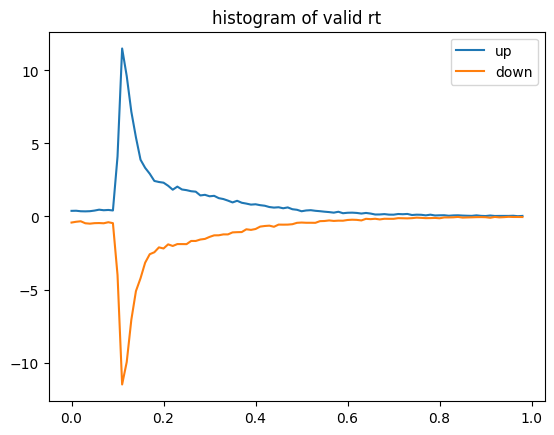

In [10]:
valid_rt_up = [res['rt'] - res['t_stim'] for res in valid_sim_res if res['choice'] == 1]
valid_rt_down = [res['rt'] - res['t_stim'] for res in valid_sim_res if res['choice'] == -1]

# hist
bins = np.arange(0, 1, 0.01)
valid_up_rt_hist, _ = np.histogram(valid_rt_up, bins=bins, density=True)
valid_down_rt_hist, _ = np.histogram(valid_rt_down, bins=bins, density=True)


plt.plot(bins[:-1], valid_up_rt_hist, label='up')
plt.plot(bins[:-1], -valid_down_rt_hist, label='down')
plt.legend()
plt.title('histogram of valid rt');

# likelihood theory and sim

# rho A 

In [11]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


# P btn 1 and 2

In [12]:
def decay_integral(t, gamma, mu_d, sigma_d, alpha):
    part1 = gamma * (1 - np.exp(-t / gamma))

    log_term_t = np.log(1 + np.exp((t - mu_d) / sigma_d))
    log_term_0 = np.log(1 + np.exp(- mu_d / sigma_d))
    part2 = alpha * sigma_d * (log_term_t - log_term_0)

    return part1 + part2

def Phi(x):
    """
    Define the normal cumulative distribution function Φ(x) using erf
    """
    return 0.5 * (1 + my_erf(x / np.sqrt(2)))

def P_small_t_btn_x1_x2_vectorized(x1, x2, t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, decay_params, K_max):
    """
    Vectorized version of the P_small_t_btn_x1_x2 function.
    Computes the integration of P_small(x,t) between x1 and x2.
    """
    gamma, mu_d, sigma_d, alpha = (decay_params[k] for k in ["gamma", "mu_d", "sigma_d", "alpha"])

    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E * q_e

    chi = 17.37
    mu = theta_E * (rate_lambda * ILD / chi)
    z = (Z_E / theta) + 1.0

    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    t_normalized = omega * decay_integral(t, gamma, mu_d, sigma_d, alpha)

    # Compute sqrt(t_normalized)
    sqrt_t = np.sqrt(t_normalized)
    
    # Handle potential division by zero
    sqrt_t = np.where(sqrt_t == 0, 1e-10, sqrt_t)

    # Create an array of n values from -K_max to K_max inclusive
    n = np.arange(-K_max, K_max + 1)

    # Compute exponentials for term1 and term2
    exp_term1 = np.exp(4 * mu * n)
    exp_term2 = np.exp(2 * mu * (2 * (1 - n) - z))

    # Compute arguments for Phi functions in term1
    phi1_upper = (x2 - (z + 4 * n + mu * t_normalized)) / sqrt_t
    phi1_lower = (x1 - (z + 4 * n + mu * t_normalized)) / sqrt_t

    # Compute Phi for term1
    Phi_term1 = Phi(phi1_upper) - Phi(phi1_lower)

    # Compute arguments for Phi functions in term2
    phi2_upper = (x2 - (-z + 4 * (1 - n) + mu * t_normalized)) / sqrt_t
    phi2_lower = (x1 - (-z + 4 * (1 - n) + mu * t_normalized)) / sqrt_t

    # Compute Phi for term2
    Phi_term2 = Phi(phi2_upper) - Phi(phi2_lower)

    # Compute term1 and term2
    term1 = exp_term1 * Phi_term1
    term2 = exp_term2 * Phi_term2

    # Compute the result by summing over all n
    result = np.sum(term1 - term2)

    return result


# CDF E minus

In [13]:
def M(x):
    """Mills ratio."""
    x = np.clip(x, -20, 20)
    return np.sqrt(np.pi / 2) * erfcx(x / np.sqrt(2))


def phi(x):
    """Standard Gaussian function."""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

def CDF_E_minus_small_t_NORM_fn_vectorized(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max):
    """
    Vectorized version of the CDF of hitting the lower bound in normalized time.
    Utilizes custom phi and M functions.

    Parameters:
    - t (float or np.ndarray): Time variable(s).
    - ABL, ILD, rate_lambda, T_0, theta_E, Z_E (float): Model parameters.
    - bound (int): Bound flag (0 or 1).
    - K_max (int): Maximum k value for summation.

    Returns:
    - np.ndarray: CDF values corresponding to each t.
    """
    gamma, mu_d, sigma_d, alpha = (decay_params[k] for k in ["gamma", "mu_d", "sigma_d", "alpha"])

    # Convert t to a NumPy array for vectorized operations
    t = np.asarray(t, dtype=np.float64)
    
    # Initialize the CDF result array with zeros
    CDF = np.zeros_like(t, dtype=np.float64)
    
    # Create a boolean mask where t > 0
    mask = t > 0
    
    if not np.any(mask):
        # If all t <= 0, return the initialized CDF (all zeros)
        return CDF
    
    # Extract only the t values where t > 0 for computation
    t_valid = t[mask]
    
    q_e = 1
    theta = theta_E * q_e

    chi = 17.37
    v = theta_E * (rate_lambda * ILD / chi)
    w = (Z_E + theta) / (2 * theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w

    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    t_normalized = omega * decay_integral(t_valid, gamma, mu_d, sigma_d, alpha)

    # Compute the exponential component of the CDF
    result = np.exp(-v * a * w - ((v ** 2) * t_normalized) / 2)

    # Create the k array
    k = np.arange(K_max + 1)
    
    # Determine even indices
    is_even = (k % 2 == 0).astype(float)
    
    # Compute r_k using broadcasting
    r_k = k * a + a * np.where(is_even, w, 1 - w)  # Shape: (K_max + 1,)
    
    # Compute sqrt(t_normalized) and handle zero to avoid division by zero
    sqrt_t = np.sqrt(t_normalized)
    sqrt_t = np.where(sqrt_t == 0, 1e-10, sqrt_t)  # Shape: (num_valid_t,)
    
    # Reshape r_k and sqrt_t for broadcasting
    # r_k: (K_max +1, 1)
    # sqrt_t: (1, num_valid_t)
    # This allows broadcasting to compute r_k / sqrt_t for all combinations
    r_k = r_k[:, np.newaxis]  # Shape: (K_max +1, 1)
    sqrt_t = sqrt_t[np.newaxis, :]  # Shape: (1, num_valid_t)
    
    phi_args = r_k / sqrt_t  # Shape: (K_max +1, num_valid_t)
    
    M_args_positive = (r_k - v * t_normalized) / sqrt_t  # Shape: (K_max +1, num_valid_t)
    M_args_negative = (r_k + v * t_normalized) / sqrt_t  # Shape: (K_max +1, num_valid_t)
    
    assert np.all(np.isfinite(phi_args)), "phi_args contains invalid values"
    assert np.all(np.isfinite(M_args_positive)), "M_args_positive contains invalid values"
    assert np.all(np.isfinite(M_args_negative)), "M_args_negative contains invalid values"

       
    phi_vals = phi(phi_args)  # Assuming phi is vectorized: Shape: (K_max +1, num_valid_t)
    M_vals = M(M_args_positive) + M(M_args_negative)  # Assuming M is vectorized

    ### M values are infinitely large for inputs less than -10 ###
    invalid_M_vals = ~np.isfinite(M_vals)
    if np.any(invalid_M_vals):
        print("Invalid M_vals detected:")
        invalid_indices = np.argwhere(invalid_M_vals)
        num_to_print = min(2, len(invalid_indices))
        for i in range(num_to_print):
            k_idx, t_idx = invalid_indices[i]
            print(f"M_vals[{k_idx}, {t_idx}] = {M_vals[k_idx, t_idx]}")
            print(f"M_args_positive[{k_idx}, {t_idx}] = {M_args_positive[k_idx, t_idx]}")
            print(f"M_args_negative[{k_idx}, {t_idx}] = {M_args_negative[k_idx, t_idx]}")
            print("---")

    assert np.all(np.isfinite(M_vals)), "M_vals contains invalid values"
    
    sign = (-1) ** k  # Shape: (K_max +1,)
    sign = sign[:, np.newaxis]  # Shape: (K_max +1, 1)
    
    summation = np.sum(sign * phi_vals * M_vals, axis=0)  # Shape: (num_valid_t,)
    
    CDF_valid = result * summation  # Shape: (num_valid_t,)
    
    CDF[mask] = CDF_valid
    
    return CDF


# rho E minus

In [14]:
def rho_E_minus_small_t_NORM_fn(t, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max):
    """
    in normalized time, PDF of hitting the lower bound
    """
    gamma, mu_d, sigma_d, alpha = (decay_params[k] for k in ["gamma", "mu_d", "sigma_d", "alpha"])

    if t <= 0:
        return 0
    
    q_e = 1
    theta = theta_E*q_e 

    chi = 17.37
    v = theta_E * (rate_lambda * ILD / chi)
    w = (Z_E + theta)/(2*theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w

    # t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    # t /= t_theta
    # Compute t_theta and normalize t
    omega = (2 / (T_0 * (theta_E**2))) * (10 ** (rate_lambda * ABL / 20))  
    dtau_by_dt = omega * decay_amount_tied_fn(t, gamma, mu_d, sigma_d, alpha)
    
    t = omega * decay_integral(t, gamma, mu_d, sigma_d, alpha)

    non_sum_term = (1/a**2)*(a**3/np.sqrt(2*np.pi*t**3))*np.exp(-v*a*w - (v**2 * t)/2)
    K_max = int(K_max/2)
    k_vals = np.linspace(-K_max, K_max, 2*K_max + 1)
    sum_w_term = w + 2*k_vals
    sum_exp_term = np.exp(-(a**2 * (w + 2*k_vals)**2)/(2*t))
    sum_result = np.sum(sum_w_term*sum_exp_term)

    
    density =  non_sum_term * sum_result
    if density <= 0:
        density = 1e-16

    return density * dtau_by_dt


# cum A 

In [15]:
def cum_A_t_fn(t, V_A, theta_A):
    """
    For AI, calculate cummulative distrn of a time t given V_A, theta_A
    """
    if t <= 0:
        return 0

    term1 = Phi(V_A * ((t) - (theta_A/V_A)) / np.sqrt(t))
    term2 = np.exp(2 * V_A * theta_A) * Phi(-V_A * ((t) + (theta_A / V_A)) / np.sqrt(t))
    return term1 + term2

In [16]:
def up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params ,K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = [rho_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]
    P_EA_btn_1_2 = [P_small_t_btn_x1_x2_vectorized(1, 2, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, decay_params, K_max) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_stim - t_E_aff
        t2 = t - t_stim
        P_E_plus_cum[i] = CDF_E_minus_small_t_NORM_fn_vectorized(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) \
                    - CDF_E_minus_small_t_NORM_fn_vectorized(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max)


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm

In [17]:
def down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params ,K_max):
    """
    PDF of up RTs array
    """
    bound = -1

    P_A = [rho_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]
    P_EA_btn_1_2 = [P_small_t_btn_x1_x2_vectorized(0, 1, t - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, decay_params, K_max) for t in t_pts]
    P_E_plus_cum = np.zeros(len(t_pts))
    for i,t in enumerate(t_pts):
        t1 = t - t_stim - t_E_aff
        t2 = t - t_stim
        P_E_plus_cum[i] = CDF_E_minus_small_t_NORM_fn_vectorized(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) \
                    - CDF_E_minus_small_t_NORM_fn_vectorized(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max)


    P_E_plus = [rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, decay_params, K_max) for t in t_pts]
    C_A = [cum_A_t_fn(t-t_A_aff, V_A, theta_A) for t in t_pts]

    P_A = np.array(P_A); P_EA_btn_1_2 = np.array(P_EA_btn_1_2); P_E_plus = np.array(P_E_plus); C_A = np.array(C_A)
    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm

# testing likelihood fn

In [18]:
# t_pts = np.arange(0, 1, 0.01)
# ABL = ABL_arr[0]
# ILD = ILD_arr[0]
# t_stim = t_stim_arr[0] 
# theory_up_rt = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, 10)
# theory_down_rt = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params, 10)
# bins = np.arange(0, 1, 0.01)
# plt.plot(t_pts-t_stim, theory_up_rt, color='r', ls='--')
# plt.plot(t_pts-t_stim, -theory_down_rt, color='r', ls='--', label='theory')

# valid_up_rt_hist, _ = np.histogram(valid_rt_up, bins=bins, density=True)
# valid_down_rt_hist, _ = np.histogram(valid_rt_down, bins=bins, density=True)

# N_up = len(valid_rt_up)
# N_down = len(valid_rt_down)

# plt.plot(bins[:-1], valid_up_rt_hist*(N_up/N_sim), label='up')
# plt.plot(bins[:-1], -valid_down_rt_hist*(N_down/N_sim), label='down')

# plt.legend()
# plt.title('histogram of valid rt');

# # data
# print(f'area under theory = {trapezoid(theory_up_rt, t_pts)}')
# print(f'area under sim = {trapezoid(valid_up_rt_hist, bins[:-1]) * (N_up/N_sim)}')



# VBMC

## loglike

In [19]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha):
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['choice']

    rt = row['rt']
    t_stim = row['t_stim']
    
    K_max = 10
    decay_params = {'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha}
    if choice == 1:
        likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params ,K_max)[0]
    elif choice == -1:
        likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, decay_params ,K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha = params


    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha)\
                                       for row in sim_results if row['rt'] > row['t_stim'])

    loglike = np.sum(all_loglike)
    return loglike

# Bounds

In [20]:
rate_lambda_bounds = [0.05, 0.3]         # true = 0.2
T_0_bounds         = [0.5e-3, 1.5e-3]     # true = 1e-3
theta_E_bounds     = [10, 30]             # true = 20
t_E_aff_bounds     = [0.05, 0.15]         # true = 0.10 sec
Z_E_bounds         = [-10, 10]            # true = 0

gamma_bounds       = [0.01, 0.1]          # true = 0.035
mu_d_bounds        = [0.05, 0.15]         # true = 0.1
sigma_d_bounds     = [0.01, 0.1]          # true = 0.05
alpha_bounds       = [0.1, 0.5]           # true = 0.3

### 
rate_lambda_plausible_bounds = [0.15, 0.25]
T_0_plausible_bounds         = [0.8e-3, 1.2e-3]
theta_E_plausible_bounds     = [15, 25]
t_E_aff_plausible_bounds     = [0.08, 0.12]
Z_E_plausible_bounds         = [-5, 5]

gamma_plausible_bounds       = [0.03, 0.05]
mu_d_plausible_bounds        = [0.08, 0.12]
sigma_d_plausible_bounds     = [0.03, 0.07]
alpha_plausible_bounds       = [0.25, 0.35]

# prior

In [21]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    mu_d_logpdf = trapezoidal_logpdf(mu_d, mu_d_bounds[0], mu_d_plausible_bounds[0], mu_d_plausible_bounds[1], mu_d_bounds[1])
    sigma_d_logpdf = trapezoidal_logpdf(sigma_d, sigma_d_bounds[0], sigma_d_plausible_bounds[0], sigma_d_plausible_bounds[1], sigma_d_bounds[1])
    alpha_logpdf = trapezoidal_logpdf(alpha, alpha_bounds[0], alpha_plausible_bounds[0], alpha_plausible_bounds[1], alpha_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + gamma_logpdf + mu_d_logpdf + sigma_d_logpdf + alpha_logpdf


# prior + loglike

In [22]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

# run vbmc

In [23]:
# Lower bounds (lb)
lb = np.array([
    rate_lambda_bounds[0],    # rate_lambda lower bound
    T_0_bounds[0],            # T_0 lower bound
    theta_E_bounds[0],        # theta_E lower bound
    t_E_aff_bounds[0],        # t_E_aff lower bound
    Z_E_bounds[0],            # Z_E lower bound
    gamma_bounds[0],          # gamma lower bound
    mu_d_bounds[0],           # mu_d lower bound
    sigma_d_bounds[0],        # sigma_d lower bound
    alpha_bounds[0]           # alpha lower bound
])

# Upper bounds (ub)
ub = np.array([
    rate_lambda_bounds[1],    # rate_lambda upper bound
    T_0_bounds[1],            # T_0 upper bound
    theta_E_bounds[1],        # theta_E upper bound
    t_E_aff_bounds[1],        # t_E_aff upper bound
    Z_E_bounds[1],            # Z_E upper bound
    gamma_bounds[1],          # gamma upper bound
    mu_d_bounds[1],           # mu_d upper bound
    sigma_d_bounds[1],        # sigma_d upper bound
    alpha_bounds[1]           # alpha upper bound
])

# Plausible lower bounds (plb)
plb = np.array([
    rate_lambda_plausible_bounds[0],
    T_0_plausible_bounds[0],
    theta_E_plausible_bounds[0],
    t_E_aff_plausible_bounds[0],
    Z_E_plausible_bounds[0],
    gamma_plausible_bounds[0],
    mu_d_plausible_bounds[0],
    sigma_d_plausible_bounds[0],
    alpha_plausible_bounds[0]
])

# Plausible upper bounds (pub)
pub = np.array([
    rate_lambda_plausible_bounds[1],
    T_0_plausible_bounds[1],
    theta_E_plausible_bounds[1],
    t_E_aff_plausible_bounds[1],
    Z_E_plausible_bounds[1],
    gamma_plausible_bounds[1],
    mu_d_plausible_bounds[1],
    sigma_d_plausible_bounds[1],
    alpha_plausible_bounds[1]
])

# --------------------------------------------------
# Next, set an initial guess (x0) for the parameters by drawing
# uniformly from the plausible bounds.
# --------------------------------------------------
np.random.seed(42)  # for reproducibility

rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0         = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0     = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_E_aff_0     = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0         = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
gamma_0       = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
mu_d_0        = np.random.uniform(mu_d_plausible_bounds[0], mu_d_plausible_bounds[1])
sigma_d_0     = np.random.uniform(sigma_d_plausible_bounds[0], sigma_d_plausible_bounds[1])
alpha_0       = np.random.uniform(alpha_plausible_bounds[0], alpha_plausible_bounds[1])

# Combine the initial parameter values in the correct order:
x0 = np.array([
    rate_lambda_0,
    T_0_0,
    theta_E_0,
    t_E_aff_0,
    Z_E_0,
    gamma_0,
    mu_d_0,
    sigma_d_0,
    alpha_0
])

# --------------------------------------------------
# Now you can use these in your VBMC call (or any optimization routine)
# --------------------------------------------------
# For example:
# vbmc = VBMC(psiam_tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
# vp, results = vbmc.optimize()

In [24]:
from pyvbmc import VBMC

vbmc = VBMC(psiam_tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 9).
Reshaping upper bounds to (1, 9).
Reshaping plausible lower bounds to (1, 9).
Reshaping plausible upper bounds to (1, 9).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       27018.31      6636.40          inf        2        inf     start warm-up
     1         15       29884.08      5389.69      6329.82        2        inf     
     2         20       32730.38      3168.53     11990.96        2   1.53e+05     
     3         25       32112.51      1668.57      4842.45        2   6.14e+04     
     4         30       32139.96       883.72      4206.46        2   4.98e+04     
     5         35       32354.08       602.68       553.85        2   8.88e+03     
     6         40       32458.67       453.44       939.30        2   1.23e+04     
     7         45       33097.84       799.6

In [25]:
# vbmc.save('psiam_tied_decay_sim_fit_vbmc.pkl')

# diagnostics

In [26]:
# import pickle
# with open('psiam_tied_decay_sim_fit_vbmc.pkl', 'rb') as f:
#     vp = pickle.load(f)

# vp = vp.vp

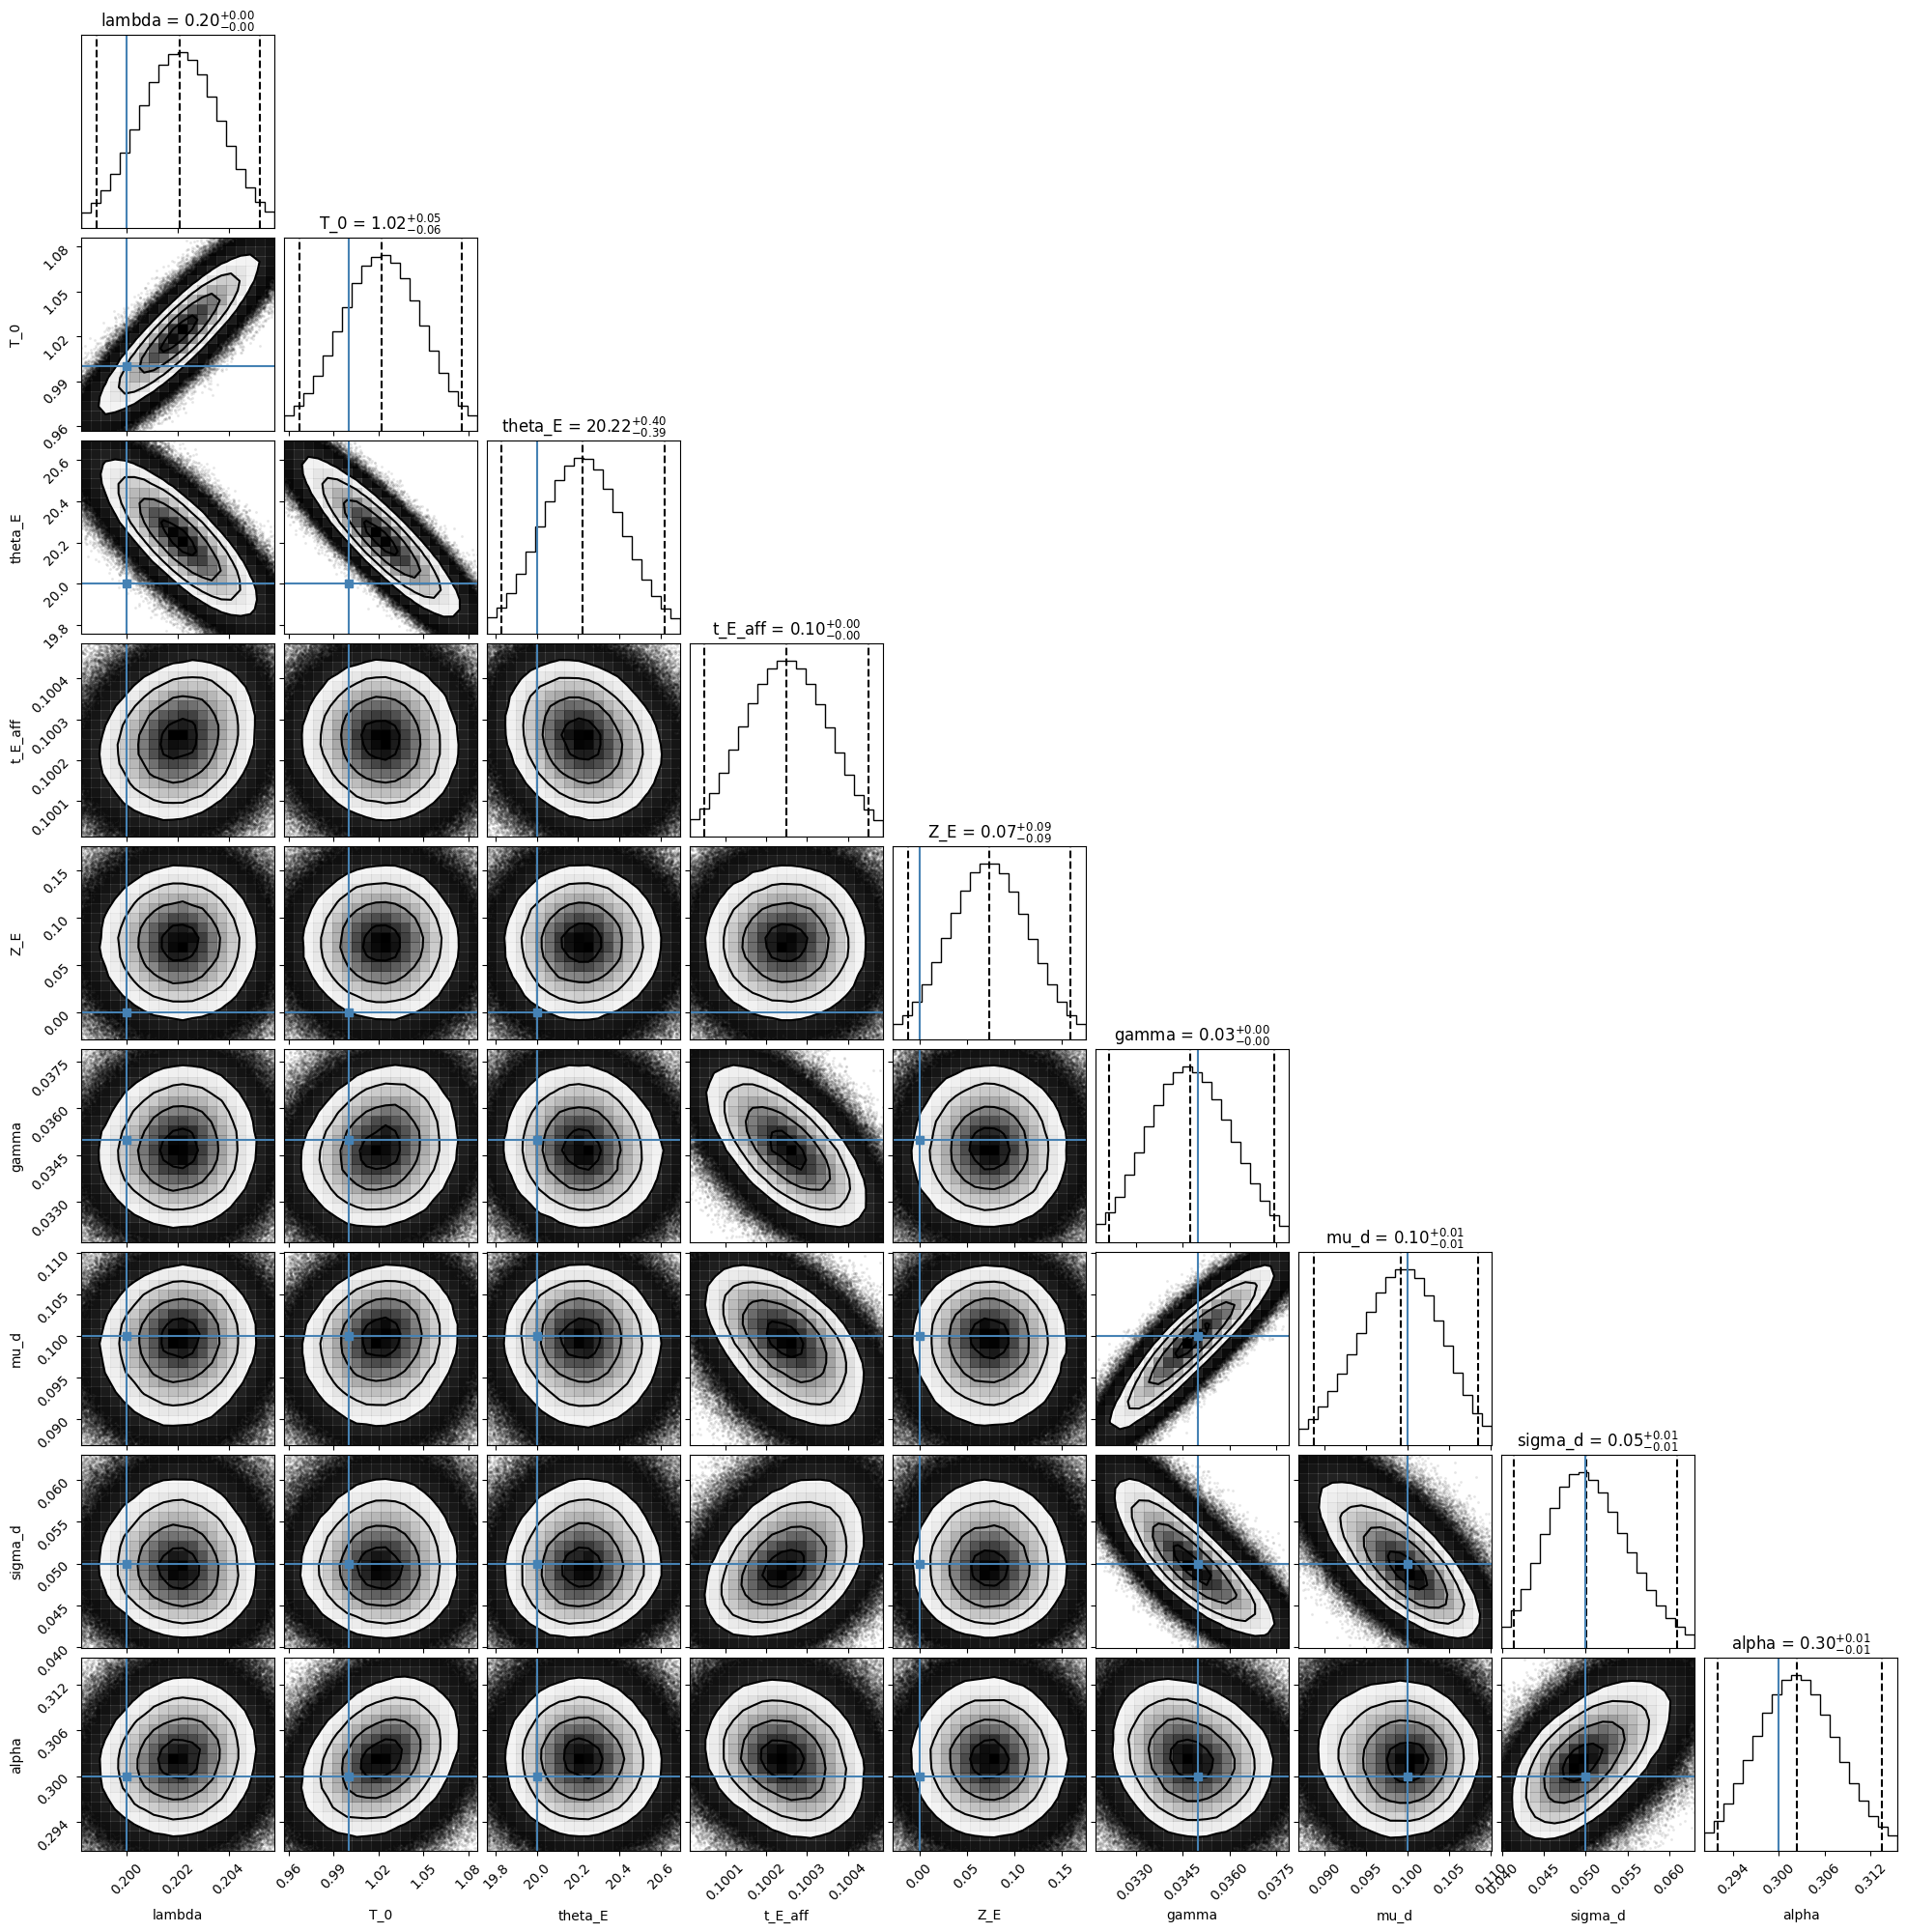

In [28]:
vp_samples = vp.sample(int(1e6))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

# rate_lambda, T_0, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha = params
param_labels = ['lambda', 'T_0', 'theta_E', 't_E_aff', 'Z_E', 'gamma', 'mu_d', 'sigma_d', 'alpha']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]

true_values = [rate_lambda, T_0*1e3, theta_E, t_E_aff, Z_E, gamma, mu_d, sigma_d, alpha]
# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    truths=true_values
);